In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
from PIL import ImageEnhance
from htgCrap import htgCrap
import cv2
import matplotlib.pyplot as plt
import os
import paddle as paddle
import paddle.fluid as fluid
import PIL.Image as Image
import random
import numpy as np
import time
from fourcrop import htgCrap
from PIL import ImageEnhance

In [15]:
def read_image(image_path):
    image = np.array(Image.open(image_path))
    htgCrapAPI = htgCrap(image)
    result = htgCrapAPI.crapFormula()
    return result

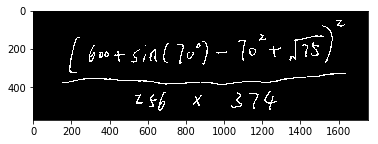

In [16]:
image_path = 'test_image/400.jpg'
formulas = np.array(read_image(image_path))
plt.figure()
plt.imshow(formulas,'Greys')

In [17]:
def cropCharContours(formula):
    _,contours,hierarchy= cv2.findContours(formula, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    x_lenth = formula.shape[1]
    y_lenth = formula.shape[0]
    temp_image = np.zeros((y_lenth,x_lenth))
    #父轮廓与子轮廓结合
    temp_contours = [[] * 1 for i in range(len(hierarchy[0]))]
    total_len = np.sum(np.array([len(contour) for contour in contours]))
    total_avg = total_len/len(hierarchy[0])
    total_avg /= 8
    for index in range(len(hierarchy[0])):
        father = hierarchy[0][index][3]
        if len(contours[index]) < total_avg:#过滤过小的噪点
            hierarchy[0][index][3] = 0
        for cont1 in contours[index]:#对Contours数据组进行整合处理
            temp_contours[index].append([cont1[0][0],cont1[0][1]])
        if father!=-1:#将子轮廓并入父轮廓数组中
            for cont1 in contours[index]:
                temp_contours[father].append([cont1[0][0],cont1[0][1]])
            temp_contours[index] = []
    deal_contours = []
    for index in range(len(hierarchy[0])):#将所有的父轮廓提取出来
        father = hierarchy[0][index][3]
        if father == -1:
            deal_contours.append(temp_contours[index])
    return deal_contours

In [18]:
def getCharLocation(formula):
    formula = cv2.bitwise_not(formula)
    mg = cv2.blur(formula,(2,2))#羽化
    ret, formula = cv2.threshold(mg, 10, 255,cv2.THRESH_BINARY)
    plt.figure()
    plt.imshow(formula)
    x_lenth = formula.shape[1]
    y_lenth = formula.shape[0]
    contours = cropCharContours(formula)
    charLocationList = []
    for contour in contours:
        x_min = x_lenth
        y_min = y_lenth
        x_max = 0
        y_max = 0
        for x,y in contour:
            if x < x_min:
                x_min = x
            if y < y_min:
                y_min = y
            if x > x_max:
                x_max = x
            if y > y_max:
                y_max = y
        after_contour = np.array(contour)-[x_min,y_min]
        charLocationList.append([[x_min,y_min,x_max-x_min,y_max-y_min],after_contour])
    def pxCulate(com):
        x_min = com[0][0]
        y_min = com[0][1]
        return x_min
    charLocationList.sort(key=pxCulate)
    return charLocationList

In [19]:
def cropChar(formulas):
    locas = getCharLocation(formulas)
    result_image = []
    for loca in locas:
        after_contour = loca[1]
        x_min,y_min,x_lenght,y_lenght = loca[0]
        lable_image = np.array(Image.new('L',(x_lenght+10,y_lenght+10)))
        for index in after_contour:
            x = index[0]+5
            y = index[1]+5
            lable_image[y][x]=255
        mask = np.zeros([lable_image.shape[0]+2, lable_image.shape[1]+2], np.uint8)
        copy_image = lable_image
        cv2.floodFill(copy_image, mask,(0,0), (99 , 0, 0), cv2.FLOODFILL_MASK_ONLY)
        def find_point(read_image):
            y = int(read_image.shape[0]/2)
            light_flage = False
            frist_falge = False
            black_flage = False
            find_x = -1
            find_y = -1
            for i in range(int(read_image.shape[1])):
                if light_flage == False and read_image[y][i] == 255:
                    light_flage = True
                elif light_flage == True and frist_falge == False and read_image[y][i] == 0:
                    black_flage = True
                    frist_falge = True
                    find_x = i
                    find_y = y
                elif light_flage == True and black_flage == True and read_image[y][i] == 255:
                    return find_x,find_y
            return 0,0
        cv2.floodFill(copy_image, mask,find_point(copy_image), (255 , 255, 255), cv2.FLOODFILL_MASK_ONLY)
        _,copy_image = cv2.threshold(copy_image,127,255,cv2.THRESH_BINARY)
#         plt.figure()
#         plt.imshow(copy_image,'Greys')
        h,w = copy_image.shape
        data_shape = 50
        printBack = Image.new('L',(64,64))
        if w>h:
            h = int(data_shape*(h/w))
            w = data_shape
            copy_image = Image.fromarray(copy_image).resize((w,h))
        else:
            w = int(data_shape*(w/h))
            h = data_shape
            copy_image = Image.fromarray(copy_image).resize((w,h))
        printBack.paste(copy_image,(int((64-w)/2),int((64-h)/2)))
        hds = np.sum(np.array(printBack)==255)#计算收缩的肥胖程度,解决是否缩放
        sfd = 1
        print(hds)
        if hds<70:
            sfd = 7
        elif hds<150:
            sfd = 5
        elif hds<300:
            sfd = 3
        mg = cv2.blur(np.array(printBack),(sfd,sfd))#羽化
        ret, printBack = cv2.threshold(mg, 1, 255,cv2.THRESH_BINARY)
        result_image.append([loca[0],printBack])
    return result_image

14
108
335
679
683
406
332
602
347
392
497
286
158
182
739
502
780
142
222
380
190
275
833
668
305
409
169
278
429
102
518


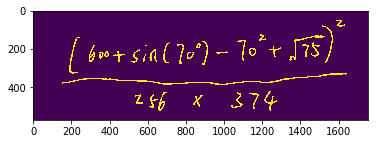

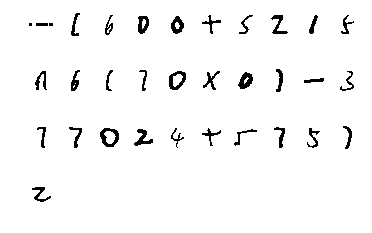

In [20]:
result_char = cropChar(formulas)
def showCropChar():
    plt.figure()
    num_len = len(result_char)
    y_axis = num_len/10+1
    cout = 0
    for char in result_char:
        cout+=1
        plt.subplot(y_axis,10,cout)
        plt.imshow(char[1],'Greys')
        plt.axis('off')
showCropChar()

In [21]:
data_shape = 64
def load_model(model_id):
    model_net_path = 'models/infer_model/'+str(model_id)+'/'
    place = fluid.CPUPlace()
    exe = fluid.Executor(place)
    [infer_program, feeded_var_names, target_var] = fluid.io.load_inference_model(dirname=model_net_path, executor=exe)
    return exe, infer_program , feeded_var_names , target_var

def model_infer(image,*args):
    exe, infer_program , feeded_var_names , target_var = args[0]
    image = np.array(image).reshape(-1,1,data_shape,data_shape).astype('float32')
    image = (image) /255.0
    result = exe.run(program = infer_program,
                    feed = {feeded_var_names[0]:image},
                     fetch_list = target_var
                    )
    return result

In [22]:
args = load_model(3)

In [23]:
def inferImage():
    formula_list = []
    for fl in result_char:
        result = model_infer(fl[1],args)
        re_str = ""
        math_map = ['0','1','2','3','4','5','6','7','8','9','(',')','+','-','*','/','=','a','t','s','n','sqrt','.','PI','y','Pi','sq']
        for i in result[0]:
            re = np.argmax(i)
            re_str+=math_map[re]
        formula_list.append(re_str)
    return formula_list

In [26]:
char_list = inferImage()

def child_belong_in(father_position,child_position):#子数字是否在父数字里面
    fx,fy,fw,fh = father_position
    cx,cy,cw,ch = child_position
    if cx>fx and cx+cw<fx+fw:#判断是否在里面，比如分数
        return True
    else:
        return False

def child_belong_position(father_position,child_position):#子数字在父数字的什么位置，1上面，2中间，3下面,4在外面
    fx,fy,fw,fh = father_position
    cx,cy,cw,ch = child_position
    if child_belong_in(father_position,child_position):#如果在父数字里面
        if cy+ch < fy+0.1*fh:#在上面
            return 1
        elif cy > fy+0.6*fh:#在下面
            return 3
        elif cx+cw<fx+0.5*fw and cy+ch<fy+0.7*fh:#针对根号
            return 1
        else:
            return 2
    else:#除此之外还有在右边，比如平方和小数点，以size做标准,特殊操作
        cs = cw*ch
        fs = fw*fh
        if cx < fx+(fw*2-(cy+ch-fy)):
            print(child_position)
            if cs < fs * 0.3:#小于部分体积
                if cy+ch < fy+0.3*fh:#在上面
                    return 1
                elif cy > fy+0.7*fh:#在下面
                    return 3
                else:
                    return 4
            elif cs < fs:#若小于大体积 针对于°
                if cy+ch < fy:#全在上面则返回上面
                    return 1
                elif cy > fy+fh:
                    return 3
                else:
                    return 4
            elif cx < fx+fw:
                if cy+ch < fy:#全在上面则返回上面
                    return 1
                elif cy > fy + fh:
                    return 3
                else:
                    return 4 
            elif cx+cw<fx+0.5*fw and cy+ch<fy+0.5*fh:#针对根号
                return 1
            else:
                return 4
        else:
            return 4



def iter_fill():
    char_index = 0
    re_arr = []
    while char_index<len(result_char):
        if char_index == 0:
            re_arr.append([char_list[char_index],[],[],[],result_char[char_index][0]])
        else:
            fcp = re_arr[len(re_arr)-1][4]
            tcp = result_char[char_index][0]
            fc = re_arr[len(re_arr)-1][0]
            tc = char_list[char_index]
            if fc == 'sq' and tc == '-':#sqrt减号
                cbp = 4
            else:
                cbp = child_belong_position(fcp,tcp)
            itarr = re_arr
            while cbp != 4:
                itarr = itarr[len(itarr)-1][cbp]
                if len(itarr) != 0:
                    fcp = itarr[len(itarr)-1][4]
                    cbp = child_belong_position(fcp,tcp)
                else:
                    break
            itarr.append([char_list[char_index],[],[],[],result_char[char_index][0]])
        char_index+=1
    return re_arr
    
iter_fill()
#     #第一步 扫描num_array区域是否存在子属关系
#     last_index = len(fill_array)
#     if last_index != 0 and depth == 0:
#         tfcp = fill_array[last_index][4]#取最后一个元素
#         cp = child_belong_position(tfcp,check_array)#检测位置
#         if cp!=4:#如果不在外面
#             fill_array = fill_array[cp]
#             arr , index = iter_fill(fill_array,cp,chile_index+1,depth+1)
#         else:#在外面，则返回
#             this_char = char_list[chile_index]
#             new_array = [this_char,[],[],[],result_char[chile_index][0]]
#             fill_array.append(new_array)
#             return fill_array,chile_index+1
#             #继续递归
#     else:
#         this_char = char_list[chile_index]
#         new_array = [this_char,[],[],[],result_char[chile_index][0]]
#         fill_array.append(new_array)
        
            

[855, 173, 23, 26]
[1182, 127, 37, 33]
[1512, 79, 57, 195]
[1587, 50, 48, 36]


[['-',
  [['(', [], [], [], [189, 139, 56, 191]],
   ['6', [], [], [], [293, 180, 33, 89]],
   ['0', [], [], [], [347, 217, 22, 35]],
   ['0', [], [], [], [374, 213, 24, 33]],
   ['+', [], [], [], [421, 212, 60, 57]],
   ['s', [], [], [], [513, 204, 49, 70]],
   ['1', [], [], [], [575, 230, 16, 38]],
   ['n', [], [], [], [609, 203, 40, 65]],
   ['(', [], [], [], [682, 169, 33, 107]],
   ['7', [], [], [], [754, 176, 35, 106]],
   ['0', [['0', [], [], [], [855, 173, 23, 26]]], [], [], [805, 216, 37, 39]],
   [')', [], [], [], [886, 159, 30, 126]],
   ['-', [], [], [], [959, 215, 59, 12]],
   ['7', [], [], [], [1070, 155, 44, 110]],
   ['0',
    [['2', [], [], [], [1182, 127, 37, 33]]],
    [],
    [],
    [1129, 198, 39, 39]],
   ['+', [], [], [], [1234, 187, 65, 58]],
   ['sqrt',
    [],
    [['7', [], [], [], [1408, 178, 34, 67]],
     ['5', [], [], [], [1456, 168, 45, 73]]],
    [],
    [1342, 131, 184, 133]],
   [')',
    [['2', [], [], [], [1587, 50, 48, 36]]],
    [],
    [],
    [

In [27]:
sl = iter_fill()

def judge_minuts_sign(ar):#判断减号 1减号 2除号 3分数 4等号
    lu = len(ar[1])#上面次数
    lm = len(ar[2])#中间的次数
    ld = len(ar[3])#下面次数
    if lu==0 and ld==0:
        return 1
    elif (lu==0 and ld==1 and lm==0 and ar[3][0][0] in ['-']) or (lu==1 and ld==0 and lm==0 and ar[1][0][0] in ['-']):
        return 4
    elif lu==1 and ld==1:
        lun = ar[1][0][0]
        ldn = ar[3][0][0]
        keyarr = ['0','1','.','(',')']
        if lun in keyarr and ldn in keyarr:
            return 2
        else:
            return 3
    elif lm==1 and ld==1:
        lun = ar[2][0][0]
        ldn = ar[3][0][0]
        keyarr = ['0','1','.','(',')']
        if (lun in keyarr) and (ldn in keyarr):
            return 2
        else:
            return 3
    elif lu==1 and lm==1:
        lun = ar[1][0][0]
        ldn = ar[2][0][0]
        keyarr = ['0','1','.','(',')']
        if (lun in keyarr) and (ldn in keyarr):
            return 2
        else:
            return 3
    else:
        return 3

def judge_normal_char(ar):#判断普通符号，0无,1小数点、2次幂、3都有
    lu = len(ar[1])
    ld = len(ar[3])
    if lu==0 and ld==0:
        return 0
    elif lu>0 and ld==0:
        return 2
    elif ld>0 and lu==0:
        return 1
    else:
        return 3
        
def judge_tragle_sign(ar):#返回具体的字符和迭代次数
    fc = ar[0][0]
    le = len(ar)
    if fc=='s' or fc == '5':
        if le>=3 and ar[2][0]=='n':
            return 'sin',3
        elif le>=4 and ar[3][0]=='n':
            return 'sin',4
        elif le>=2 and ar[1][0]=='-' and fc=='s':
            return '5',2
        else:
            return '5',1
    elif fc=='(' and le>=3:
        if ar[1][0] == '0' and (ar[2][0] == 's' or ar[2][0]=='5'):
            return 'cos',3
        elif len(ar[0][1])>=1 and ar[0][1][0][0] == '-':
            return '5',1
        elif len(ar[0][2])>=1 and ar[0][2][0][0] == '-':
            return '5',1
        else:
            return '(',1
    elif fc=='t' and le>=3:
        if ar[1][0] == 'a' and ar[2][0] == 'n':
            return 'tan',3
        else:
            return 't',1
    else:
        return fc,1

    

def disposeChildText(array):
    ct = ''
    aid = 0
    while aid<len(array):
        ar = array[aid]
        fc = ar[0]
        aidn = 1
        if fc == '-':#减号特殊，除号and分数and减号
            ms = judge_minuts_sign(ar)
            if ms==1:
                ct+='-'
            elif ms==2:
                ct+='/'
            elif ms==4:
                ct+='='
            elif ms==3:
                ctup = disposeChildText(ar[1])
                ctdown = disposeChildText(ar[3])
                ct+='(('+ctup+')/('+ctdown+'))'
        elif fc=='s' or fc=='(' or fc=='t' or fc == '5':#处理sin cos tan
            cts , aidn = judge_tragle_sign(array[aid:])
            if cts=='5' and aidn==1 and len(ar[1])>1:
                ct+='5^'+disposeChildText(ar[1][1:])
            else:
                ct+=cts
        elif fc=='Pi':#π的左半边
            ct+='PI'
            aidn=2
        elif fc=='sqrt':#根号
            sqn = '2'
            if len(ar[1])>0:
                sqn = disposeChildText(ar[1])
            sqi = disposeChildText(ar[2])
            ct+='sqrt'+sqn+'('+sqi+')'
        elif fc=='sq':#分开的根号
            sqn = '2'
            if len(ar[1]) > 0 :
                sqn = disposeChildText(ar[1])
            sqi = disposeChildText(array[aid+1][3])
            ct+='sqrt'+sqn+'('+sqi+')'
            aidn=2
        else:#处理正常数字
            jnc = judge_normal_char(ar)
            if jnc==0:
                ct+=fc
            elif jnc==1:
                ct+=fc+'.'
            elif jnc==2 or jnc==3:
                ctup = disposeChildText(ar[1])
                glarr = ['+','-','*','/','(',')','s','t','y','a']
                if ctup not in glarr:
                    ct+=fc+'^('+ctup+')'
                if jnc==3:
                    ct+='.'
        aid+=aidn
    return ct

print(disposeChildText(sl))

def getResultText(sort_list):
    pass

[855, 173, 23, 26]
[1182, 127, 37, 33]
[1512, 79, 57, 195]
[1587, 50, 48, 36]
(((600+sin(70^(0))-70^(2)+sqrt2(75))^(2))/(256*374))


In [28]:
############################第一种方案

In [29]:
text = ""
char_list = inferImage()
char_index = 0
def char_list_sort():
    father_char_position = [0,0,0,0]
    sort_char_list = result_char
    char_index = 0
    father_char_index = -1
    while(char_index<len(result_char)):
        char = result_char[char_index][0]
        plus_number = 1
        father_x_start = father_char_position[0]
        father_x_end = father_char_position[0]+father_char_position[2]
        char_x_start = char[0]
        char_x_end = char[0]+char[2]
        father_size = father_char_position[2]*father_char_position[3]
        char_size = char[2]*char[3]
        father_y_start = father_char_position[1]
        father_y_end = father_char_position[1]+father_char_position[3]
        char_y_start = char[1]
        char_y_end = char[1]+char[3]
        is_in = not((char_x_start > father_x_start) and (char_x_end < father_x_end))
        is_up = not(char_size < father_size and char_y_end < father_y_start+father_char_position[3]/3)
        is_down = not(char_size < father_size/6 and char_y_start > father_y_start+father_char_position[3]-father_char_position[3]/3)
        is_include = (char_y_start < father_y_start and char_y_end > father_y_end)
        print(char_list[char_index],is_in,is_up,is_down,is_include)
        def text_del(fChar):
            plus_number=1
            #sin值
            if fChar == 's':
                if char_index+3<len(result_char) and char_list[char_index+3]=='n' and (char_list[char_index+1]=='1' or char_list[char_index+2]=='1'):
                    fChar = 'sin'
                    plus_number=4
                elif char_index+2<len(result_char) and char_list[char_index+2]=='n' and char_list[char_index+1]=='1':
                    fChar = 'sin'
                    plus_number=3
                else:
                    fChar = '5'
            #cos值
            if fChar == '(':
                if char_index+2<len(result_char) and char_list[char_index+1]=='0' and (char_list[char_index+2]=='s' or char_list[char_index+2]=='5'):
                    fChar = 'cos'
                    plus_number=3
            #tan值
            if fChar == 't':
                if char_index+2<len(result_char) and char_list[char_index+1]=='a' and char_list[char_index+2]=='n':
                    fChar = 'tan'
                    plus_number=3
            return fChar,plus_number
        if (is_in and is_up and is_down) or is_include:
            fChar = char_list[char_index]
            fChar,plus_number = text_del(fChar)
            #######
            sort_char_list.append([fChar,[],[],[]])
            father_char_position = char
            father_char_index += 1
        else:
            fChar = char_list[char_index]
            if fChar == 's':
                fChar = '5'
            if char_y_start<father_y_start+father_char_position[3]*0.1:#在上面
                sort_char_list[father_char_index][1].append(fChar)
            elif char_y_start>father_y_start+father_char_position[3]*0.5:
                sort_char_list[father_char_index][3].append(fChar)
            else:
                sort_char_list[father_char_index][2].append(fChar)
        char_index+=plus_number
    return sort_char_list
char_list_sort()

- True True True False
( False False True False


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [ ]:
sort_list = char_list_sort()

In [ ]:
char_index = 0
text = ""
for father in sort_list:
    math_map = ['0','1','2','3','4','5','6','7','8','9','(',')','+','-','*','/','=','a','t','s','n','sqrt','.','PI','y']
    this_char = father[0]
    plus_number = 1
    index = -1
    if (this_char in math_map):
        index = math_map.index(this_char)
    #123456789（）
    if index < 12:
        text+=this_char
        if len(father[1])>0:
            text+='^'
            for i in father[1]:
                text+=i
        if len(father[3])>0 and (father[3][0]=='.' or father[3][0]=='0' or father[3][0]=='8' or father[3][0]=='4' or father[3][0]=='6' or father[3][0]=='9'):
            text+='.'
    #减号
    elif this_char == '-':
        if len(father[1])!=0 and len(father[3])!=0:
            if len(father[1])==1 and len(father[3])==1:
                dianchar = ['.','1','0']
                if (father[1][0] in dianchar) and (father[1][0] in dianchar):
                    text+='/'
                    continue
            fenshu = ''
            up = ''
            down = ''
            for i in father[1]:
                up+=i
            for i in father[3]:
                down+=i
            fenshu='(('+up+')/('+down+'))'
            text+=fenshu
        elif len(father[1])==0 and len(father[3])==1 and father[3][0]=='-':
            text+='='
        elif len(father[1])==1 and len(father[3])==0 and father[1][0]=='-':
            text+='='
        else:
            text+='-'
    elif this_char == 'sqrt':
        up=''
        if len(father[1])==0:
            text+='sqrt2'
        else:
            text+='sqrt'+str(father[1][0])
        for i in father[2]:
            up+=str(i)
        text+='('+up+')'
    else:
        text+=this_char
    char_index+=plus_number
print(text)

In [ ]:
# while(char_index<len(char_list)):
#     is_Five = False
#     is_Divide = False
#     is_Equals = False
#     thisChar = char_list[char_index]
#     lenList = len(char_list)
#     #处理555555555555
#     if (thisChar == '(' or thisChar == ')' or thisChar == '5') and char_index+1 < lenList and char_list[char_index+1] == '-':
#         d1 = result_char[char_index][0]
#         d2 = result_char[char_index+1][0]
#         d1_min = d1[0]
#         d1_max = d1_min + d1[2]
#         d2_min = d2[0]
#         print(d1,d2,d2_min > d1_max)
#         if (d1_min <= d2_min and d1_max >= d2_min) or (d2_min > d1_max and ((d1[1]+d1[3]/3) > d2[1])):
#             text+='5'
#             is_Five=True
    
    
#     #处理等号====================
#     if thisChar == '-' and char_index+1 <lenList and char_list[char_index+1] == '-':
#         if (d1[0] < d2[0] and d1[0]+d1[2]>d2[0]) or (d2[0]<d1[0] and d2[0]+d2[2]>d1[0]):
#             text+='='
#             is_Equals=True
            
            
#     #处理分数and除号//////////////////////
#     if thisChar == '-' and char_index+2 <lenList and char_list[char_index+1] == '1' and char_list[char_index+1] == '1':
#         text+='/'
#         is_Divide=True
#     if thisChar == '-' and char_index+2 <lenList and char_list[char_index+1] == '0':
#         text+='/'
#         is_Divide=True
    
    
#     #正常数字合并
#     if is_Five == False and is_Divide == False and is_Equals == False:
#         text+=thisChar
    
#     #合并
#     if is_Five == True or is_Equals == True:
#         char_index+=2
#     elif is_Divide == True:
#         char_index+=3
#     else:
#         char_index+=1
# print(text)